In [1]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# import joblib

# # 1) Load datasets
# calories = pd.read_csv("../data/calories.csv")
# exercise = pd.read_csv("../data/exercise.csv")

# # 2) Clean column names
# calories.columns = calories.columns.str.strip().str.lower()
# exercise.columns = exercise.columns.str.strip().str.lower()

# # 3) Merge datasets on user_id
# df = pd.merge(exercise, calories, on="user_id")

# print(df.head())

# # 4) Features and target
# FEATURES = ["age", "height", "weight", "duration", "heart_rate", "body_temp"]
# TARGET = "calories"

# X = df[FEATURES]
# y = df[TARGET]

# # 5) Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 6) Train model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # 7) Save trained model
# joblib.dump(model, "../models/calorie_model.pkl")

# print("✅ Model trained and saved to ../models/calorie_model.pkl")

In [2]:
# from sklearn.metrics import mean_squared_error, r2_score

# y_pred = model.predict(X_test)
# print("R²:", r2_score(y_test, y_pred))
# print("MSE:", mean_squared_error(y_test, y_pred))

# df

In [3]:
# from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor(n_estimators=200, random_state=42)
# rf.fit(X_train, y_train)

# print("RF R²:", rf.score(X_test, y_test))

Data preview:
    user_id  gender  age  height  weight  duration  heart_rate  body_temp  \
0  14733363    male   68   190.0    94.0      29.0       105.0       40.8   
1  14861698  female   20   166.0    60.0      14.0        94.0       40.3   
2  11179863    male   69   179.0    79.0       5.0        88.0       38.7   
3  16180408  female   34   179.0    71.0      13.0       100.0       40.5   
4  17771927  female   27   154.0    58.0      10.0        81.0       39.8   

   calories  
0     231.0  
1      66.0  
2      26.0  
3      71.0  
4      35.0  

Linear Regression Results:
R²: 0.9845
MSE: 62.41

Random Forest Results:
R²: 0.9957
MSE: 17.33

XGBoost Results:
R²: 0.9967
MSE: 13.5

Cross-Validation Results:
Linear Regression CV R²: 0.9844
Random Forest CV R²: 0.9953
XGBoost CV R²: 0.9963

✅ Best model: XGBoost saved to ../models/calorie_model.pkl


<Figure size 1000x600 with 0 Axes>

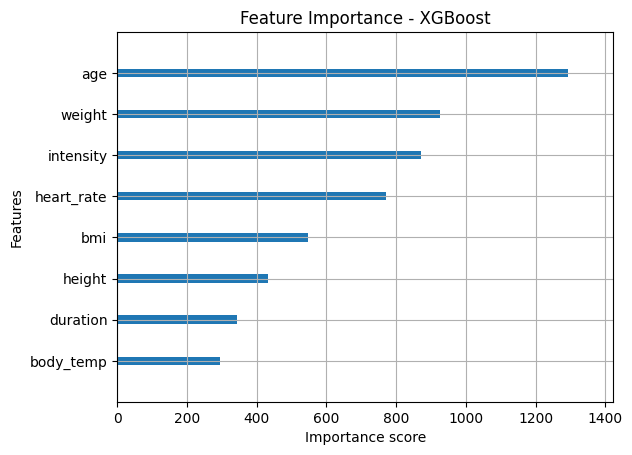

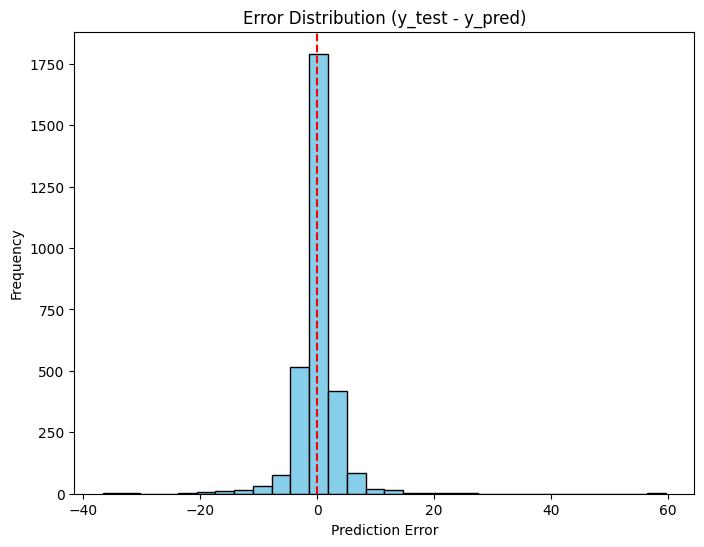

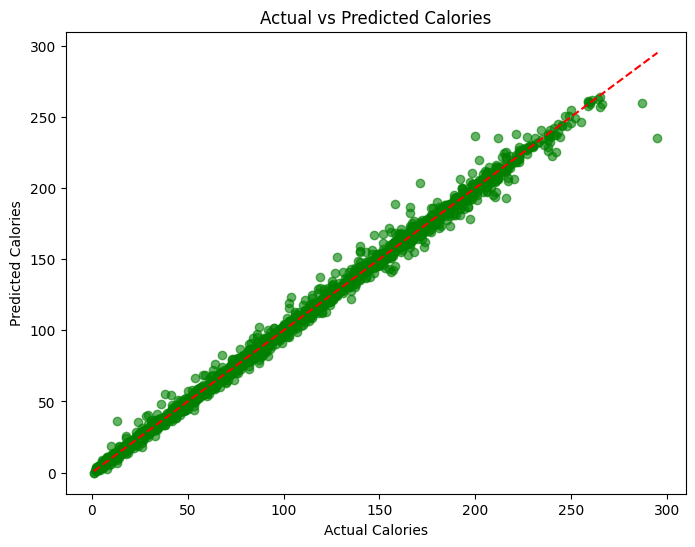

In [4]:
# =============================
# 1. Import Libraries
# =============================
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor

# =============================
# 2. Load Datasets
# =============================

# Calories dataset + exercise dataset (your original)
calories = pd.read_csv("../data/calories.csv")
exercise = pd.read_csv("../data/exercise.csv")

# Clean column names
calories.columns = calories.columns.str.strip().str.lower()
exercise.columns = exercise.columns.str.strip().str.lower()

# Merge datasets on user_id
df = pd.merge(exercise, calories, on="user_id")

print("Data preview:")
print(df.head())

# =============================
# 3. Feature Engineering
# =============================
# Create BMI feature
df["bmi"] = df["weight"] / (df["height"] / 100) ** 2

# Create intensity feature
df["intensity"] = df["duration"] * df["heart_rate"]

# Define features & target
FEATURES = [
    "age",
    "height",
    "weight",
    "duration",
    "heart_rate",
    "body_temp",
    "bmi",
    "intensity",
]
TARGET = "calories"

X = df[FEATURES]
y = df[TARGET]

# =============================
# 4. Train/Test Split
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =============================
# 5. Train Models
# =============================
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
    ),
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    results[name] = {"R2": r2, "MSE": mse}
    print(f"\n{name} Results:")
    print("R²:", round(r2, 4))
    print("MSE:", round(mse, 2))

# =============================
# 6. Cross Validation
# =============================
print("\nCross-Validation Results:")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    print(f"{name} CV R²: {np.mean(scores):.4f}")

# =============================
# 7. Save Best Model
# =============================
# Pick the model with best R²
best_model_name = max(results, key=lambda x: results[x]["R2"])
best_model = models[best_model_name]

joblib.dump(best_model, "../models/calorie_model.pkl")
print(f"\n✅ Best model: {best_model_name} saved to ../models/calorie_model.pkl")

# =============================
# 8. Feature Importance (XGBoost)
# =============================
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(best_model, importance_type="weight", show_values=False)
plt.title("Feature Importance - XGBoost")
plt.show()

# =============================
# 9. Error Distribution Plot
# =============================
y_pred = best_model.predict(X_test)
errors = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color="skyblue", edgecolor="black")
plt.axvline(0, color="red", linestyle="--")
plt.title("Error Distribution (y_test - y_pred)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

# =============================
# 10. Actual vs Predicted Plot
# =============================
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="green")
plt.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--"
)  # ideal line
plt.title("Actual vs Predicted Calories")
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.show()

In [5]:
df.head(12)

,user_id,gender,age,height,weight,duration,heart_rate,body_temp,calories,bmi,intensity
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,26.038781,3045.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,21.773842,1316.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,24.655910,440.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,22.159109,1300.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,24.456063,810.0
5,15130815,female,36,151.0,50.0,23.0,96.0,40.7,123.0,21.928863,2208.0
6,19602372,female,33,158.0,56.0,22.0,95.0,40.5,112.0,22.432303,2090.0
7,11117088,male,41,175.0,85.0,25.0,100.0,40.7,143.0,27.755102,2500.0
8,12132339,male,60,186.0,94.0,21.0,97.0,40.4,134.0,27.170771,2037.0
9,17964668,female,26,146.0,51.0,16.0,90.0,40.2,72.0,23.925690,1440.0
